# Using synthetic data, test `xclim` QDM functionality

Feb 2021

Following x`clim/xclim/testing/tests/test_sdba/diagnostics.py`

Note: the notebook installs `xclim` from a local clone that can be edited (hence a bunch of debugging output below). 

Also test local updates to the `xclim` package


In [25]:
# pip install -e /home/jovyan/xclim 

Obtaining file:///home/jovyan/xclim
  Attempting uninstall: xclim
    Found existing installation: xclim 0.23.2b0
    Uninstalling xclim-0.23.2b0:
      Successfully uninstalled xclim-0.23.2b0
  Running setup.py develop for xclim
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import xarray as xr
import scipy as sp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 



In [2]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [3]:
write_direc = '../figures/' #'/gcs/rhg-data/climate/downscaled/workdir'

In [5]:
import xclim
from xclim import sdba


## QDM 

I messed with my local copy of `xclim` so there are print messages. 

In [7]:
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu


In [8]:
# straight out of diagnostics.py
n = 10000
ref, hist, sim = tu.cannon_2015_rvs(n, random=False)
    
QM = sdba.adjustment.EmpiricalQuantileMapping(kind="*", group="time")
QM.train(ref, hist)
sim_eqm = QM.adjust(sim)
    

DQM = sdba.adjustment.DetrendedQuantileMapping(kind="*", group="time")
DQM.train(ref, hist)
sim_dqm = DQM.adjust(sim, detrend=0)

QDM = sdba.adjustment.QuantileDeltaMapping(kind="*", group="time")
QDM.train(ref, hist)
sim_qdm = QDM.adjust(sim)
hist_qdm = QDM.adjust(hist)

extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
----_adjust(), self.ds @@@@@ <xarray.Dataset>
Dimensions:    (quantiles: 22)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.025 0.075 0.125 ... 0.925 0.975 1.0
Data variables:
    af         (quantiles) float64 0.3023 0.6255 0.7176 ... 1.159 1.222 1.412
    hist_q     (quantiles) float64 4.816 13.08 16.43 18.54 ... 46.17 53.81 88.93
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=20, kind='*', group=Grouper(...
extrapolate_qm @@@@@@@
----_adjust(), self.ds @@@@@ <xarray.Dataset>
Dimensions:    (quantiles: 22)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.025 0.075 0.125 ... 0.925 0.975 1.0
Data variables:
    af         (quantiles) float64 0.3023 0.6255 0.7176 ... 1.159 1.222 1.412
    hist_q     (quantiles) float64 4.816 13.08 16.43 18.54 ... 46.17 53.81 88.93
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=20, kind='*', group=Grouper(...


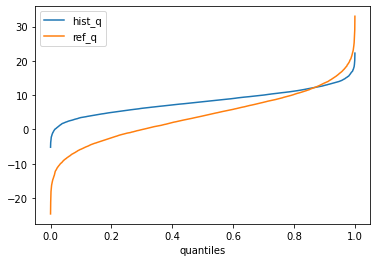

In [43]:
QDM.ds.hist_q.plot()
(QDM.ds.af+QDM.ds.hist_q).plot()
plt.legend(('hist_q','ref_q'))

### Cannon et al. 2015 Fig 2

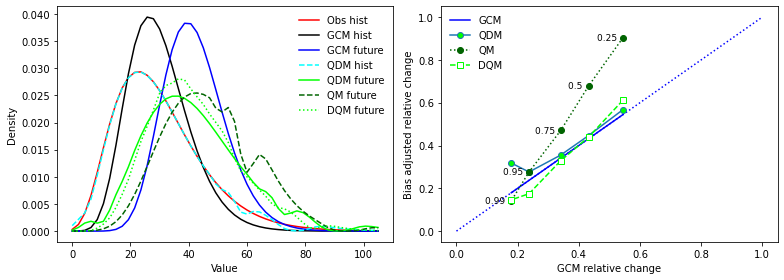

In [9]:
if 1: # copied from a func and didn't want to manually unindent
    # This comes from diagnostics.py
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    x = np.linspace(0, 105, 50)
    ax1.plot(x, gaussian_kde(ref)(x), color="r", label="Obs hist")
    ax1.plot(x, gaussian_kde(hist)(x), color="k", label="GCM hist")
    ax1.plot(x, gaussian_kde(sim)(x), color="blue", label="GCM future")

    ax1.plot(x, gaussian_kde(hist_qdm)(x), color="cyan", linestyle='dashed',label="QDM hist")

    ax1.plot(x, gaussian_kde(sim_qdm)(x), color="lime", label="QDM future")
    ax1.plot(x, gaussian_kde(sim_eqm)(x), color="darkgreen", ls="--", label="QM future")
    ax1.plot(x, gaussian_kde(sim_dqm)(x), color="lime", ls=":", label="DQM future")
    ax1.legend(frameon=False)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Density")

    tau = np.array([0.25, 0.5, 0.75, 0.95, 0.99]) * 100
    bc_gcm = (
        scoreatpercentile(sim, tau) - scoreatpercentile(hist, tau)
    ) / scoreatpercentile(hist, tau)
    bc_qdm = (
        scoreatpercentile(sim_qdm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)
    bc_eqm = (
        scoreatpercentile(sim_eqm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)
    bc_dqm = (
        scoreatpercentile(sim_dqm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)

    ax2.plot([0, 1], [0, 1], ls=":", color="blue")
    ax2.plot(bc_gcm, bc_gcm, "-", color="blue", label="GCM")
    ax2.plot(bc_gcm, bc_qdm, marker="o", mfc="lime", label="QDM")
    ax2.plot(
        bc_gcm,
        bc_eqm,
        marker="o",
        mfc="darkgreen",
        ls=":",
        color="darkgreen",
        label="QM",
    )
    ax2.plot(
        bc_gcm,
        bc_dqm,
        marker="s",
        mec="lime",
        mfc="w",
        ls="--",
        color="lime",
        label="DQM",
    )

    for i, s in enumerate(tau / 100):
        ax2.text(bc_gcm[i], bc_eqm[i], f"{s}  ", ha="right", va="center", fontsize=9)
    ax2.set_xlabel("GCM relative change")
    ax2.set_ylabel("Bias adjusted relative change")
    ax2.legend(loc="upper left", frameon=False)
#     ax2.set_aspect("equal")
    plt.tight_layout()

    

## Synth data with `kind="+"` instead of "*"

copied and adapted functions from ....`xclim/xclim/testing/tests/test_sdba/utils.py` 

In [16]:
# these funcs modified from ~/xclim/xclim/testing/tests/test_sdba/utils.py
def my_series(values, name, start="2000-01-01"):
    import collections

    
    coords = collections.OrderedDict()
    for dim, n in zip(("time", "lon", "lat"), values.shape):
        if dim == "time":
            coords[dim] = pd.date_range(start, periods=n, freq=pd.DateOffset(days=1))
        else:
            coords[dim] = xr.IndexVariable(dim, np.arange(n))

    if name == "tas":
        attrs = {
            "standard_name": "air_temperature",
            "cell_methods": "time: mean within days",
            "units": "K",
            "kind": "+",
        }
    elif name == "pr":
        attrs = {
            "standard_name": "precipitation_flux",
            "cell_methods": "time: sum over day",
            "units": "kg m-2 s-1",
            "kind": "*",
        }

    return xr.DataArray(
        values,
        coords=coords,
        dims=list(coords.keys()),
        name=name,
        attrs=attrs,
    )

def my_dist():
    from scipy.stats import norm

    # ref ~ gamma(k=4, theta=7.5)  mu: 30, sigma: 15
    ref = norm(4, scale=7.5)

    # hist ~ gamma(k=8.15, theta=3.68) mu: 30, sigma: 10.5
    hist = norm(8.15, scale=3.68)

    # sim ~ gamma(k=16, theta=2.63) mu: 42, sigma: 10.5
    sim = norm(16, scale=2.63)

    return ref, hist, sim


def my_rvs(n, random=True):
    # Frozen distributions
    fd = my_dist()

    if random:
        r = [d.rvs(n) for d in fd]
    else:
        raise NotImplementedError
#         u = equally_spaced_nodes(n, None)
#         r = [d.ppf(u) for d in fd]

    return map(lambda x: my_series(x, "tas"), r)


Now increase the number of quantiles in the bias correction *and try "+"*

In [44]:
random = True
nquantiles = 1000
n = 10000
kind = "+"

ref, hist, sim = my_rvs(n, random=random)
QM = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group="time", nquantiles=nquantiles)
QM.train(ref, hist)
sim_eqm = QM.adjust(sim)
    

DQM = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group="time", nquantiles=nquantiles)
DQM.train(ref, hist)
sim_dqm = DQM.adjust(sim, detrend=0)

QDM = sdba.adjustment.QuantileDeltaMapping(kind=kind, group="time", nquantiles=nquantiles)
QDM.train(ref, hist)
sim_qdm = QDM.adjust(sim)
hist_qdm = QDM.adjust(hist)

extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
----_adjust(), self.ds @@@@@ <xarray.Dataset>
Dimensions:    (quantiles: 1002)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.0005 0.0015 ... 0.9985 0.9995 1.0
Data variables:
    af         (quantiles) float64 -21.05 -17.74 -15.52 ... 7.9 8.847 9.61
    hist_q     (quantiles) float64 -6.088 -3.752 -2.939 ... 19.37 20.3 21.17
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=1000, kind='+', group=Groupe...
extrapolate_qm @@@@@@@
----_adjust(), self.ds @@@@@ <xarray.Dataset>
Dimensions:    (quantiles: 1002)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.0005 0.0015 ... 0.9985 0.9995 1.0
Data variables:
    af         (quantiles) float64 -21.05 -17.74 -15.52 ... 7.9 8.847 9.61
    hist_q     (quantiles) float64 -6.088 -3.752 -2.939 ... 19.37 20.3 21.17
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=1000, kind='+', group=Groupe...


In [47]:
# add a ridiculously simple trend
trend = np.linspace(0,20,len(sim.time))

simtrend = sim+trend
simtrend_qdm = QDM.adjust(simtrend)


extrapolate_qm @@@@@@@
----_adjust(), self.ds @@@@@ <xarray.Dataset>
Dimensions:    (quantiles: 1002)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.0005 0.0015 ... 0.9985 0.9995 1.0
Data variables:
    af         (quantiles) float64 -21.05 -17.74 -15.52 ... 7.9 8.847 9.61
    hist_q     (quantiles) float64 -6.088 -3.752 -2.939 ... 19.37 20.3 21.17
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=1000, kind='+', group=Groupe...


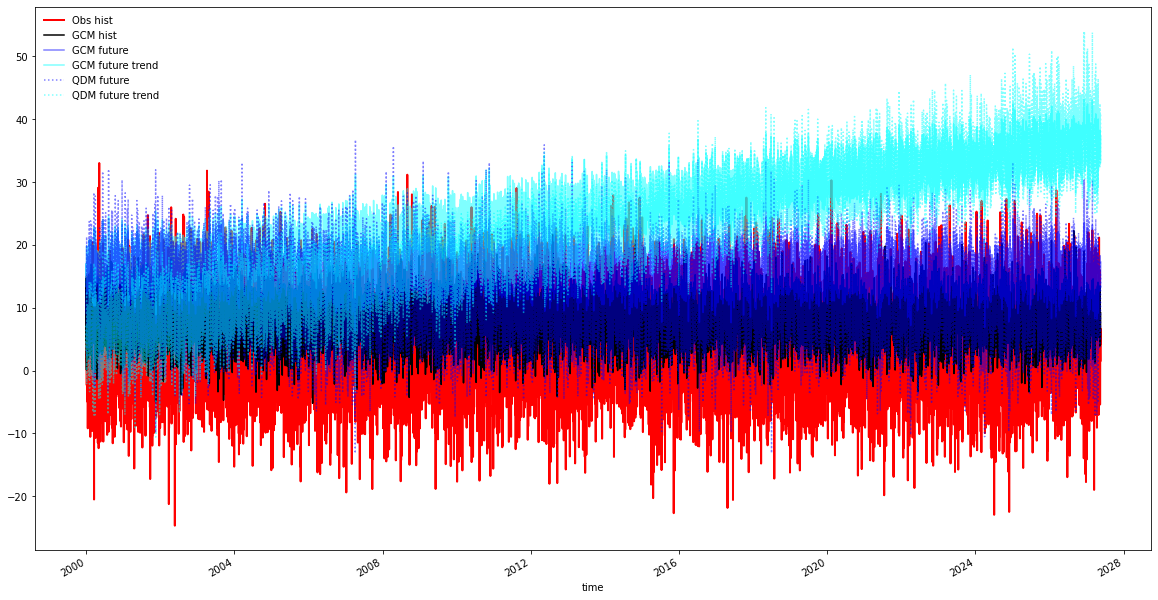

In [20]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="cyan", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

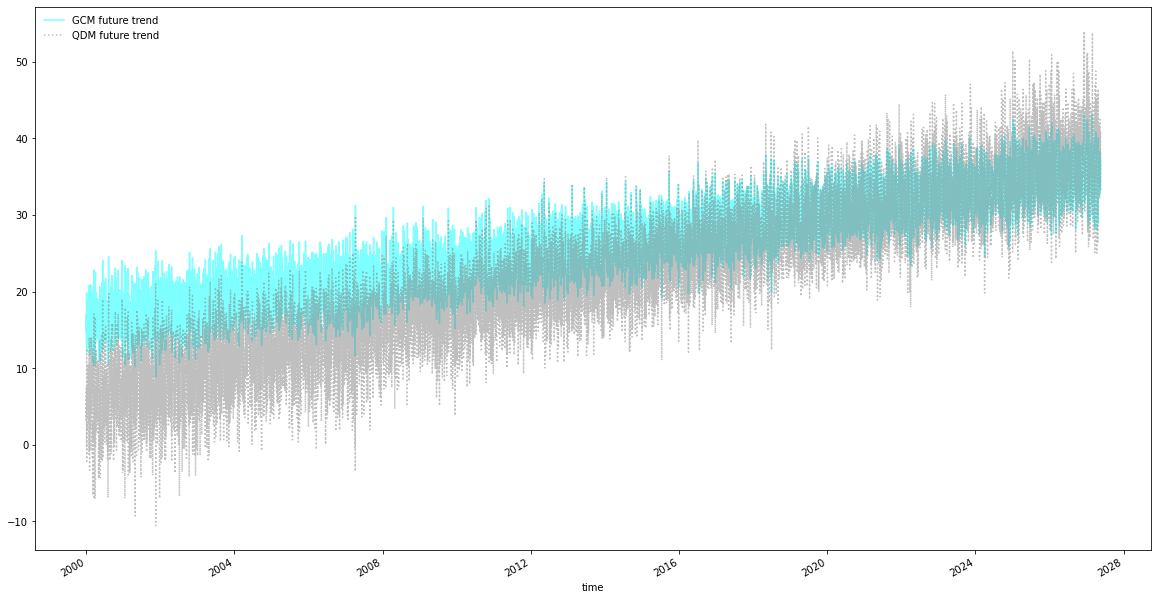

In [21]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="gray", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

In [23]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*n) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*n) # total change

print('\n  simtrend  ', sp.stats.linregress(np.arange(len(simtrend.time)), simtrend.values).slope*n)
print('  QDM simtrend', sp.stats.linregress(np.arange(len(simtrend_qdm.time)), simtrend_qdm.values).slope*n)


all days linear trend
  sim     -0.15308042633039184
  QDM sim -0.3800138464971845

  simtrend   19.848919773689612
  QDM simtrend 31.755658428565646


# is the trend preserved?
Default behavior shows that at least the trend in the mean (or the raw trend through all days) is not preserved - it gets steeper. But this may not be applicable to our actual method, which is grouped by day and will have a rolling future cdf. Not worries about this, yet



### comparing quantiles 

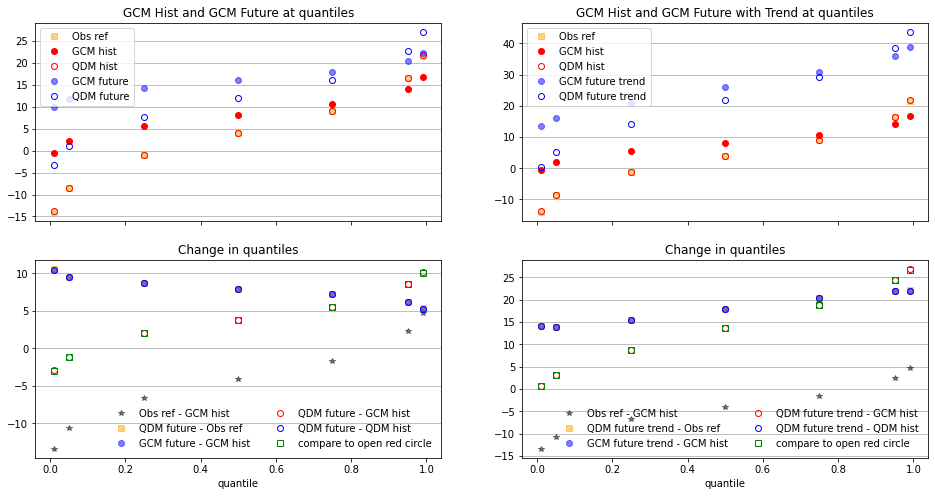

In [25]:
if kind=='*':
    kindstr='mult'
else:
    kindstr='add'
quants = [.01, .05, .25, .5, .75, .95, .99]
printtofile=True

if kind=="+":
    fig, axs = plt.subplots(2,2,figsize=(16,8),sharex=True)#, sharey=True)
    ax=axs[0,0]
    ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
    hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
    hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
    sim.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future')
    sim_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future')
    ax.legend(loc='upper left')
    ax.set_title('GCM Hist and GCM Future at quantiles')
    ax.grid(axis='y')
    ax=axs[0,1]
    ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
    hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
    hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
    simtrend.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future trend')
    simtrend_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future trend')
    ax.legend()
    ax.set_title('GCM Hist and GCM Future with Trend at quantiles')
    ax.grid(axis='y')

    ax=axs[1,0]
    (ref.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
    (sim_qdm.quantile(quants)-ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future - Obs ref')
    (sim.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future - GCM hist')
    (sim_qdm.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future - GCM hist')
    (sim_qdm.quantile(quants)-hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future - QDM hist')
    ((ref.quantile(quants)-hist.quantile(quants))+(sim.quantile(quants)-hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
    ax.legend(ncol=2, frameon=False)
    ax.set_title('Change in quantiles')
    ax.grid(axis='y')
    ax=axs[1,1]
    (ref.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
    (simtrend_qdm.quantile(quants)-ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future trend - Obs ref')
    (simtrend.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future trend - GCM hist')
    (simtrend_qdm.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future trend - GCM hist')
    (simtrend_qdm.quantile(quants)-hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future trend - QDM hist')
    ((ref.quantile(quants)-hist.quantile(quants))+(simtrend.quantile(quants)-hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
    ax.legend(ncol=2,frameon=False)
    ax.set_title('Change in quantiles')
    ax.grid(axis='y')

else:
    
    # have not tested this figure yet!! for kind="*" !!
    
    fig, axs = plt.subplots(2,2,figsize=(16,8),sharex=True)#, sharey=True)
    ax=axs[0,0]
    ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
    hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
    hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
    sim.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future')
    sim_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future')
    ax.legend(loc='upper left')
    ax.set_title('GCM Hist and GCM Future at quantiles')
    ax.grid(axis='y')
    ax=axs[0,1]
    ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
    hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
    hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
    simtrend.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future trend')
    simtrend_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future trend')
    ax.legend()
    ax.set_title('GCM Hist and GCM Future with Trend at quantiles')
    ax.grid(axis='y')

    ax=axs[1,0]
    (ref.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
    (sim_qdm.quantile(quants)/ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future - Obs ref')
    (sim.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future - GCM hist')
    (sim_qdm.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future - GCM hist')
    (sim_qdm.quantile(quants)/hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future - QDM hist')
    ((ref.quantile(quants)/hist.quantile(quants))+(sim.quantile(quants)-hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
    ax.legend(ncol=2, frameon=False)
    ax.set_title('Change in quantiles')
    ax.grid(axis='y')
    ax=axs[1,1]
    (ref.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
    (simtrend_qdm.quantile(quants)/ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future trend - Obs ref')
    (simtrend.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future trend - GCM hist')
    (simtrend_qdm.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future trend - GCM hist')
    (simtrend_qdm.quantile(quants)/hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future trend - QDM hist')
    ((ref.quantile(quants)/hist.quantile(quants))*(simtrend.quantile(quants)/hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
    ax.legend(ncol=2,frameon=False)
    ax.set_title('Change in quantiles')
    ax.grid(axis='y')
    
if printtofile:
    fig.savefig('{}/QDM_synthtest_{}_quantile_changes_subplots.png'.format(write_direc,kindstr),dpi=200, bbox_inches='tight')


The above figure analyzes the quantiles of the raw and QDM corrected synthetic time series from Cannon et al. 2015 if when `kind="*"` and adjusted to a normal dist when `kind="+"` (left), and with a fake trend applied to the same synthetic future data (right). The full time series (length defined by setting `n` in days) are quantiled, ungrouped, in this analysis, because that is what is passed to QDM as well. Currently, the right column with a trend in the future data doesn't really add much yet, so focus on the left column. **TODO: change to box and whiskers plots**

### Top row: quantiles for `Obs ref` and corrected and uncorrected `GCM hist`, `GCM future` with and without trend.

Expected behavior of applying QDM:
- GCM hist should look almost exactly like Obs ref, by design
- applying QDM should widen the quantile spread of GCM hist and GCM future because observations have a wider quantile spread than GCM hist

Realized behavior (multiplicative):
- 
- 

Realized behavior (additive):
- <span style="color:green">YES:</span> corrected GCM hist (open red) has the same quantile values as Obs ref (orange square)
- <span style="color:green">YES:</span> Comparing open circles (QDM) to closed circles (uncorrected) of the same colors, we see that quantile spread is widened in the corrected data (QDM hist and QDM future)
 

### Bottom row: the difference in the un/corrected GCM future quantiles vs the un/corrected GCM hist and Obs ref quantiles

Expected behavior:
- the quantile differences between GCM future and GCM hist (blue circle) should be preserved after applying QDM --> thus (QDM future - QDM hist) should be the same as (GCM future - GCM hist) (compare open and closed blue circle). 
    - This is because we compute the `delta` between uncorrected GCM hist and future data, then bias correct GCM future to get an observationally bias corrected future time series, and then add that delta back onto the bias corrected future GCM. Thus, the total correction should be `obs_adjustment_factor + delta`. Without adding the delta, the future data would have quantiles that match Obs ref (e.g. a difference of QDM future - Obs ref should be approx zero. Although I suspect a delta isn't be added, this also isn't true - see orange square and open blue circle. They are not zero). 
    - With the delta applied, the difference between QDM future and QDM hist should = GCM future - GCM hist.
- the quantile differences between QDM future and uncorrected GCM hist (open red circle) should look like the combination of (GCM hist-Obs ref; black star) and (GCM future-GCM hist; closed blue circle): these differences are summed and shown as open green squared
- the quantile differences between QDM future and QDM hist (blue open circle) should be equal to the differences between QDM future and Obs ref (orange square)
- the quantile differences between Obs ref and QDM hist should be zero (not shown)

Realized behavior (multiplicative):
- ...
- ...
- ...
- not shown


Realized behavior (additive):
- <span style="color:green">YES:</span> woot the quantile differences b/w uncorrected and QDM'd future and hist are preserved! open and closed blue circles are the same. As a bonus, so is orange square (QDM future - Obs ref) which is also expected
- <span style="color:green">YES:</span> QDM future - GCM hist (open red) IS the combination of (GCM hist - Obs ref; the original bias correction; black star) and the future quantile change (GCM future-GCM hist; closed blue). The open green squares are on top of the open red circles.
- <span style="color:green">YES:</span> as stated in bullet one, orange square (QDM Future - Obs ref) is the same as change in GCM quantiles (QDM future - QDM hist or GCM future - GCM hist)
- not shown

## The method works properly!
The difference from our schematic is that in our schematic, we compute the deltas (GCM Future - GCM Hist), and then *bias correct GCM Hist to match Obs Ref* to get a historical observationally corrected time series. Then we would add the deltas to the result of that to get the QDM Future time series. 

HERE, we don't bias correct GCM Hist and add to it. We just compute the mapping from GCM Hist to Obs Ref, and add it straight to GCM Future. I think it's what Bob was saying all along.

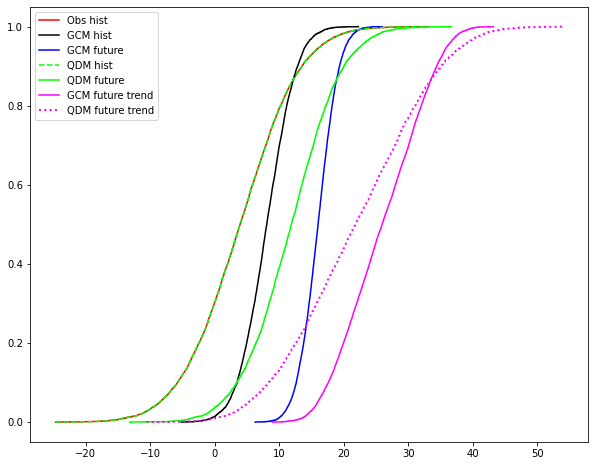

In [26]:
import statsmodels.api as sm

    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf = sm.distributions.ECDF(hist_qdm)
simqdm_ecdf = sm.distributions.ECDF(sim_qdm)
simtrend_ecdf = sm.distributions.ECDF(simtrend)
simtrendqdm_ecdf = sm.distributions.ECDF(simtrend_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="lime", linestyle='dashed', label="QDM hist")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="lime", label="QDM future")
ax.step(simtrend_ecdf.x,simtrend_ecdf.y, color="magenta", label="GCM future trend")
ax.step(simtrendqdm_ecdf.x,simtrendqdm_ecdf.y, color="magenta", linewidth=2, linestyle=":", label="QDM future trend")
ax.legend()

The following figure right panel isn't yet updated to work with "+" data. TODO update it

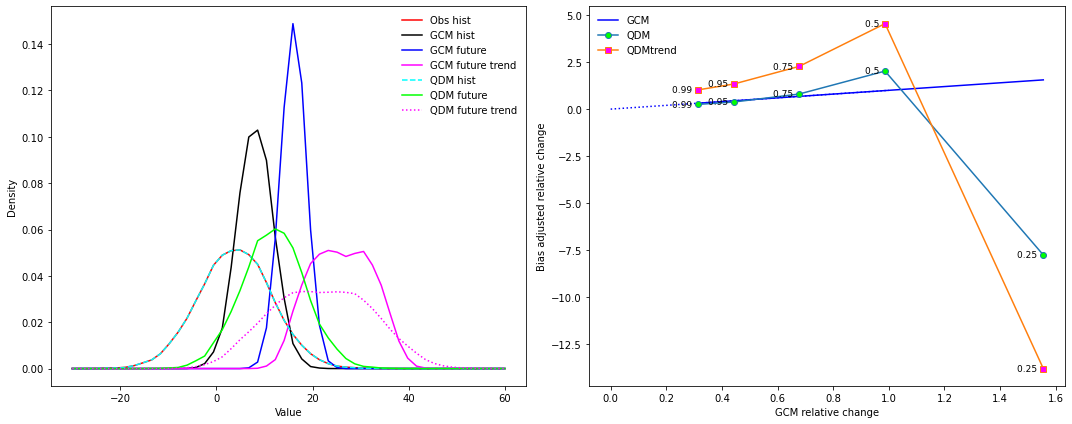

In [30]:
if 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    x = np.linspace(-30, 60, 50)
    ax1.plot(x, gaussian_kde(ref)(x), color="r", label="Obs hist")
    ax1.plot(x, gaussian_kde(hist)(x), color="k", label="GCM hist")
    ax1.plot(x, gaussian_kde(sim)(x), color="blue", label="GCM future")
    ax1.plot(x, gaussian_kde(simtrend)(x), color="magenta", label="GCM future trend")

    ax1.plot(x, gaussian_kde(hist_qdm)(x), color="cyan", linestyle='dashed',label="QDM hist")

    ax1.plot(x, gaussian_kde(sim_qdm)(x), color="lime", label="QDM future")
    ax1.plot(x, gaussian_kde(simtrend_qdm)(x), color="magenta",linestyle=":", label="QDM future trend")
#     ax1.plot(x, gaussian_kde(sim_eqm)(x), color="darkgreen", ls="--", label="QM future")
#     ax1.plot(x, gaussian_kde(sim_dqm)(x), color="lime", ls=":", label="DQM future")
    ax1.legend(frameon=False)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Density")

    tau = np.array([0.25, 0.5, 0.75, 0.95, 0.99]) * 100
    bc_gcm = (
        scoreatpercentile(sim, tau) - scoreatpercentile(hist, tau)
    ) / scoreatpercentile(hist, tau)
    bc_qdm = (
        scoreatpercentile(sim_qdm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)
    bctrend_qdm = (
        scoreatpercentile(simtrend_qdm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)
#     bc_eqm = (
#         scoreatpercentile(sim_eqm, tau) - scoreatpercentile(ref, tau)
#     ) / scoreatpercentile(ref, tau)
#     bc_dqm = (
#         scoreatpercentile(sim_dqm, tau) - scoreatpercentile(ref, tau)
#     ) / scoreatpercentile(ref, tau)

    ax2.plot([0, 1], [0, 1], ls=":", color="blue")
    ax2.plot(bc_gcm, bc_gcm, "-", color="blue", label="GCM")
    ax2.plot(bc_gcm, bc_qdm, marker="o", mfc="lime", label="QDM")
    ax2.plot(bc_gcm, bctrend_qdm, marker="s", mfc="magenta", label="QDMtrend")
#     ax2.plot(
#         bc_gcm,
#         bc_eqm,
#         marker="o",
#         mfc="darkgreen",
#         ls=":",
#         color="darkgreen",
#         label="QM",
#     )
#     ax2.plot(
#         bc_gcm,
#         bc_dqm,
#         marker="s",
#         mec="lime",
#         mfc="w",
#         ls="--",
#         color="lime",
#         label="DQM",
#     )

    for i, s in enumerate(tau / 100):
#         ax2.text(bc_gcm[i], bc_eqm[i], f"{s}  ", ha="right", va="center", fontsize=9)
        ax2.text(bc_gcm[i], bc_qdm[i], f"{s}  ", ha="right", va="center", fontsize=9)
        ax2.text(bc_gcm[i], bctrend_qdm[i], f"{s}  ", ha="right", va="center", fontsize=9)
    ax2.set_xlabel("GCM relative change")
    ax2.set_ylabel("Bias adjusted relative change")
    ax2.legend(loc="upper left", frameon=False)
#     ax2.set_aspect("equal")
    plt.tight_layout()

    